In [2]:
# ────────────────────────────────────────────────────────────────
# 1. IMPORTS & BASIC SETUP
# ────────────────────────────────────────────────────────────────

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Optional – for simple forecasting
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Better looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("muted")


print("Libraries loaded.")

Libraries loaded.


In [3]:
# ────────────────────────────────────────────────────────────────
# 2. LOAD & QUICK INSPECTION
# ────────────────────────────────────────────────────────────────


FILE = "AB_NYC_2019.csv"

df = pd.read_csv(FILE)

print("Shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())

print("\nData types:")
print(df.dtypes)

print("\nMissing values:")
print(df.isna().sum())

# Quick look at price extremes
print("\nPrice stats:")
print(df['price'].describe(percentiles=[0.01, 0.05, 0.95, 0.99]))

Shape: (48895, 16)

Columns:
['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

Data types:
id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

Missing values:


In [4]:
# Ensure we are working with the already loaded dataframe
clean_df = df.copy()

# 1. Convert last_review to datetime
clean_df['last_review'] = pd.to_datetime(clean_df['last_review'], errors='coerce')

# 2. Basic null summary
null_summary = clean_df.isnull().sum()
print(null_summary)

# 3. Basic sanity checks for id/name swaps: look for non-numeric ids or very short numeric names
id_non_numeric = clean_df[~clean_df['id'].apply(lambda x: isinstance(x, (int, float)))]
name_numeric = clean_df[clean_df['name'].astype(str).str.fullmatch(r'\d+') == True]

print(id_non_numeric.head())
print(name_numeric.head())

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64
Empty DataFrame
Columns: [id, name, host_id, host_name, neighbourhood_group, neighbourhood, latitude, longitude, room_type, price, minimum_nights, number_of_reviews, last_review, reviews_per_month, calculated_host_listings_count, availability_365]
Index: []
             id name    host_id host_name neighbourhood_group  \
5276    3816424    3    

In [5]:
# ────────────────────────────────────────────────────────────────
# 4. SAVE CLEANED VERSION
# ────────────────────────────────────────────────────────────────

df.to_csv("cleaned_AB_NYC_2019.csv", index=False)
print("Cleaned file saved → cleaned_AB_NYC_2019.csv")

Cleaned file saved → cleaned_AB_NYC_2019.csv


In [6]:
# ────────────────────────────────────────────────────────────────
# 5. BASIC DESCRIPTIVE STATISTICS & KPIs
# ────────────────────────────────────────────────────────────────

kpis = {}

kpis['Total Listings']          = len(df)
kpis['Unique Hosts']            = df['host_id'].nunique()
kpis['Avg Listings per Host']   = df.groupby('host_id').size().mean()
kpis['Total Reviews']           = df['number_of_reviews'].sum()
kpis['Avg Price']               = df['price'].mean()
kpis['Median Price']            = df['price'].median()
kpis['Avg Availability (days)'] = df['availability_365'].mean()

print("Key KPIs 2019 snapshot:")
for k, v in kpis.items():
    print(f"{k:28} : {v:,.1f}" if isinstance(v, float) else f"{k:28} : {v:,}")

# Room type distribution
print("\nRoom type distribution:")
print(df['room_type'].value_counts(normalize=True).mul(100).round(1).astype(str) + " %")

Key KPIs 2019 snapshot:
Total Listings               : 48,895
Unique Hosts                 : 37,457
Avg Listings per Host        : 1.3
Total Reviews                : 1,138,005
Avg Price                    : 152.7
Median Price                 : 106.0
Avg Availability (days)      : 112.8

Room type distribution:
room_type
Entire home/apt    52.0 %
Private room       45.7 %
Shared room         2.4 %
Name: proportion, dtype: object


'price_capped' added successfully.


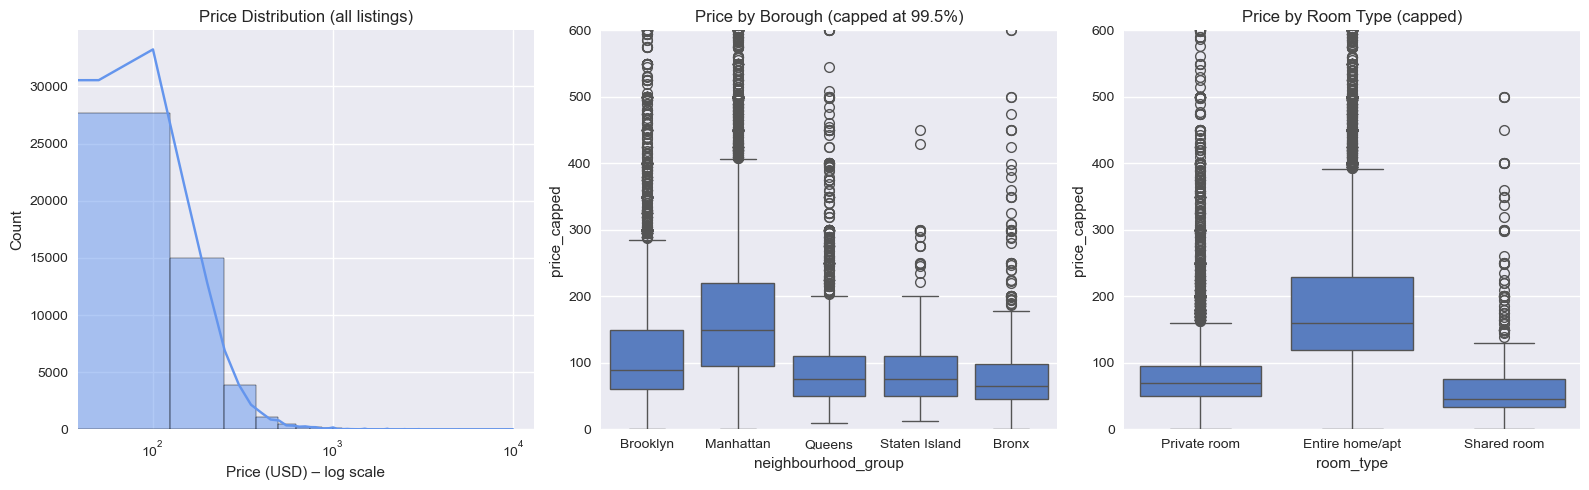

In [7]:
# ────────────────────────────────────────────────────────────────
# 6. PRICE PATTERNS – Visualizations 
# ────────────────────────────────────────────────────────────────

# Quick check if 'price_capped' exists; if not, recreate it
if 'price_capped' not in df.columns:
    print("Warning: 'price_capped' not found. Recreating it now...")
    p995 = df['price'].quantile(0.995)
    df['price_capped'] = np.where(df['price'] > p995, p995, df['price'])
    print("'price_capped' added successfully.")

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Overall price distribution (log scale helps)
sns.histplot(df['price'], bins=80, kde=True, ax=axes[0], color='cornflowerblue')
axes[0].set_title("Price Distribution (all listings)")
axes[0].set_xscale('log')
axes[0].set_xlabel("Price (USD) – log scale")

# 2. Price by borough
sns.boxplot(data=df, x='neighbourhood_group', y='price_capped', ax=axes[1])
axes[1].set_title("Price by Borough (capped at 99.5%)")
axes[1].set_ylim(0, 600)

# 3. Price by room type
sns.boxplot(data=df, x='room_type', y='price_capped', ax=axes[2])
axes[2].set_title("Price by Room Type (capped)")
axes[2].set_ylim(0, 600)

plt.tight_layout()
plt.show()

In [8]:
# ────────────────────────────────────────────────────────────────
# 7. POPULAR NEIGHBORHOODS & HOST ACTIVITY
# ────────────────────────────────────────────────────────────────

# Top 15 neighborhoods
top_neigh = df['neighbourhood'].value_counts().head(15)
print("Top 15 neighborhoods by number of listings:\n")
print(top_neigh)

# Top 10 hosts by number of listings
top_hosts = df['host_id'].value_counts().head(10)
top_hosts_df = df[df['host_id'].isin(top_hosts.index)][['host_id','host_name']].drop_duplicates()
print("\nTop 10 hosts by listing count:")
print(top_hosts)

# Most reviewed hosts (proxy for activity/success)
most_reviewed = df.groupby(['host_id','host_name'])['number_of_reviews'].sum().nlargest(10)
print("\nTop 10 hosts by total reviews:")
print(most_reviewed)

Top 15 neighborhoods by number of listings:

neighbourhood
Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
Hell's Kitchen        1958
East Village          1853
Upper East Side       1798
Crown Heights         1564
Midtown               1545
East Harlem           1117
Greenpoint            1115
Chelsea               1113
Lower East Side        911
Astoria                900
Name: count, dtype: int64

Top 10 hosts by listing count:
host_id
219517861    327
107434423    232
30283594     121
137358866    103
16098958      96
12243051      96
61391963      91
22541573      87
200380610     65
7503643       52
Name: count, dtype: int64

Top 10 hosts by total reviews:
host_id    host_name                     
37312959   Maya                              2273
344035     Brooklyn&   Breakfast    -Len-    2205
26432133   Danielle                          2017
35524316   Yasu & Akiko                      1971


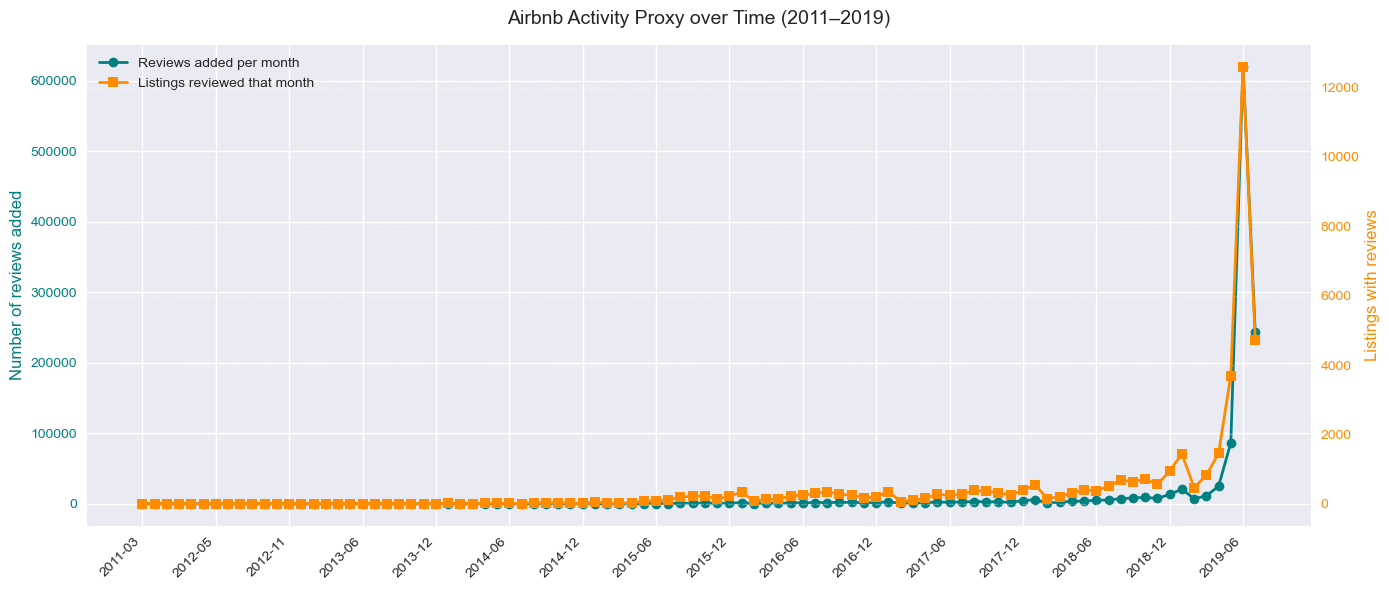

In [14]:
# ────────────────────────────────────────────────────────────────
# 8. TIME SERIES – Reviews as demand proxy (clean x-axis version)
# ────────────────────────────────────────────────────────────────

# Ensure datetime
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

# Prepare time series data again (fix for NameError)
df_ts = df[df['last_review'].notna()].copy()
df_ts['year_month'] = df_ts['last_review'].dt.to_period('M')

monthly_reviews = df_ts.groupby('year_month')['number_of_reviews'].sum()
monthly_new_listings_proxy = df_ts.groupby('year_month').size()

fig, ax1 = plt.subplots(figsize=(14, 6))

# Primary axis - reviews
ax1.plot(monthly_reviews.index.astype(str), monthly_reviews, 
         color='teal', marker='o', linewidth=2, label='Reviews added per month')
ax1.set_ylabel("Number of reviews added", color='teal', fontsize=12)
ax1.tick_params(axis='y', labelcolor='teal')

# Secondary axis - listings proxy
ax2 = ax1.twinx()
ax2.plot(monthly_new_listings_proxy.index.astype(str), monthly_new_listings_proxy, 
         color='darkorange', marker='s', linewidth=2, label='Listings reviewed that month')
ax2.set_ylabel("Listings with reviews", color='darkorange', fontsize=12)
ax2.tick_params(axis='y', labelcolor='darkorange')

# Title and grid
plt.title("Airbnb Activity Proxy over Time (2011–2019)", fontsize=14, pad=15)
fig.autofmt_xdate(rotation=45, ha='right')

# Prevent overcrowded x-axis
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.grid(True, alpha=0.3, linestyle='--')

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()


In [16]:
# Diagnostic 1: check current type of last_review
print("Column types right now:")
print(df.dtypes[['last_review', 'number_of_reviews']])

print("\nSample values of last_review:")
print(df['last_review'].head(8))
print("\nIs datetime?", pd.api.types.is_datetime64_any_dtype(df['last_review']))

Column types right now:
last_review          datetime64[ns]
number_of_reviews             int64
dtype: object

Sample values of last_review:
0   2018-10-19
1   2019-05-21
2          NaT
3   2019-07-05
4   2018-11-19
5   2019-06-22
6   2017-10-05
7   2019-06-24
Name: last_review, dtype: datetime64[ns]

Is datetime? True


In [18]:
###### Diagnostic 2: see how many valid dates we have
print("Number of rows with valid last_review date:", 
      df['last_review'].notna().sum(), "/", len(df))

Number of rows with valid last_review date: 38843 / 48895


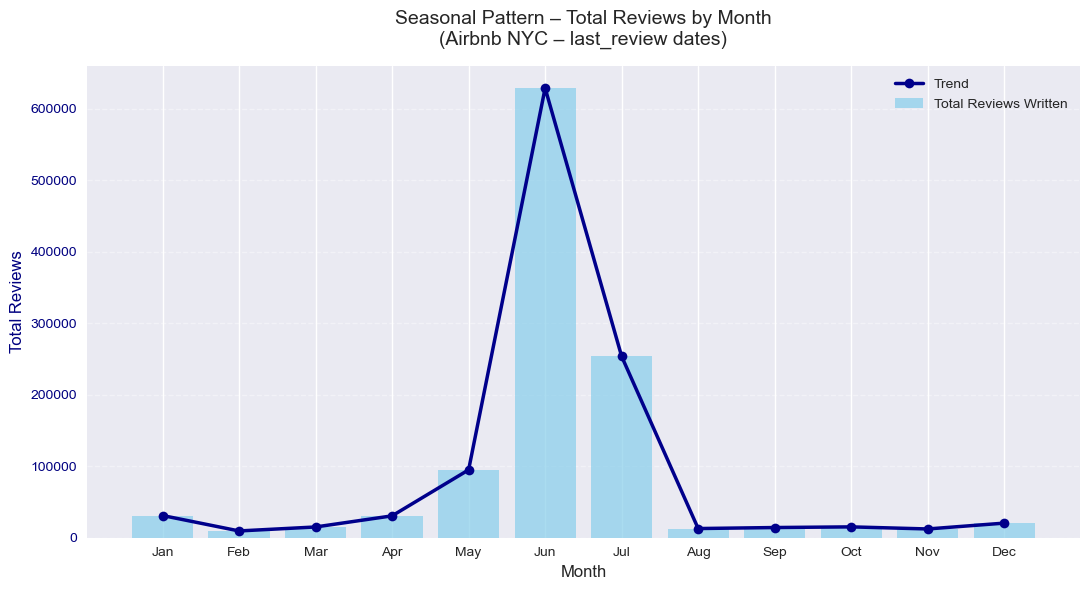

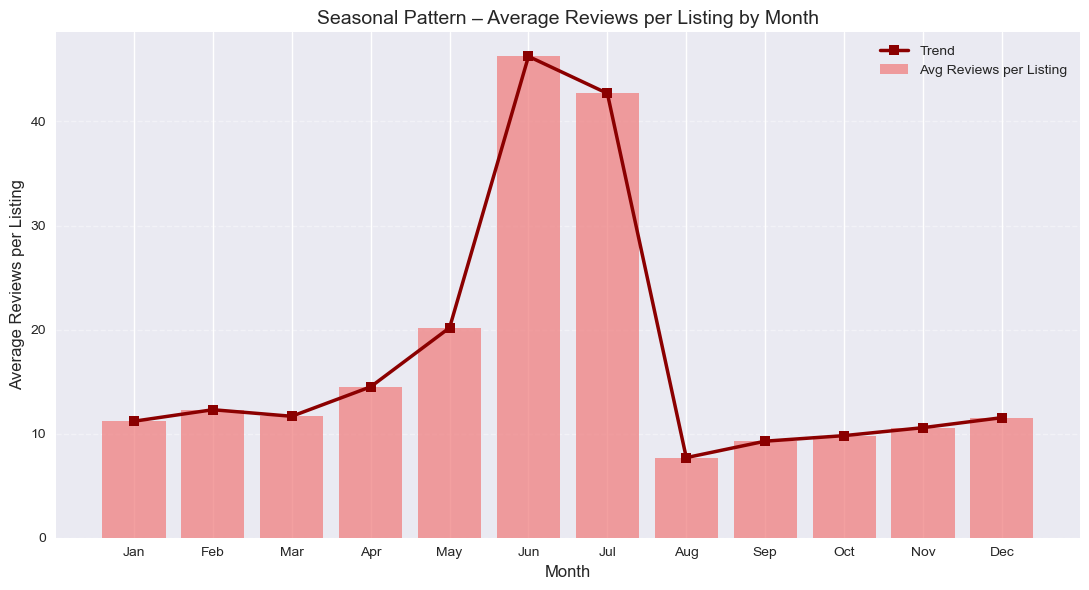


Seasonal Summary (Reviews by Month):
Month  Total Reviews  Avg per Listing  Review Events
  Jan          31045            11.20           2773
  Feb           9472            12.30            770
  Mar          15032            11.67           1288
  Apr          30588            14.50           2109
  May          94871            20.18           4701
  Jun         628570            46.26          13589
  Jul         253512            42.70           5937
  Aug          12832             7.70           1667
  Sep          14243             9.28           1535
  Oct          15168             9.81           1546
  Nov          12248            10.58           1158
  Dec          20424            11.54           1770


In [20]:
# =============================================================================
# Seasonal Pattern: Reviews by Month (Airbnb NYC 2019)
# =============================================================================


# ──── SETTINGS ──────────────────────────────────────────────────────────────
plt.style.use('seaborn-v0_8')
sns.set_palette("muted")
plt.rcParams['figure.figsize'] = (11, 6)

# ──── 1. DATA PREPARATION ───────────────────────────────────────────────────
df = pd.read_csv('AB_NYC_2019.csv')  # change path if needed

# Convert and filter valid dates
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df = df[df['last_review'].notna()].copy()

# Extract month (1–12) and short month name
df['month'] = df['last_review'].dt.month
df['month_short'] = df['last_review'].dt.month_name().str[:3]

# ──── 2. AGGREGATIONS ───────────────────────────────────────────────────────
# A. Total reviews written in each month (cumulative seasonal volume)
monthly_total = df.groupby('month')['number_of_reviews'].sum().reset_index()

# B. Average reviews per listing (intensity of activity)
monthly_avg = df.groupby('month')['number_of_reviews'].mean().reset_index()

# C. Count of reviews written per month (how many review events happened)
monthly_count = df.groupby('month').size().reset_index(name='review_count')

# Sort by calendar month
monthly_total = monthly_total.sort_values('month')
monthly_avg   = monthly_avg.sort_values('month')
monthly_count = monthly_count.sort_values('month')

# Month names for labels
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# ──── 3. PLOT 1: Total Reviews by Month (Bar + Line) ────────────────────────
fig, ax1 = plt.subplots()

# Bars: total reviews volume
bars = ax1.bar(monthly_total['month'], monthly_total['number_of_reviews'],
               color='skyblue', alpha=0.7, label='Total Reviews Written')
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Total Reviews', color='navy', fontsize=12)
ax1.tick_params(axis='y', labelcolor='navy')

# Line on same axis for trend
ax1.plot(monthly_total['month'], monthly_total['number_of_reviews'],
         color='darkblue', marker='o', linewidth=2.5, label='Trend')

# Formatting
ax1.set_title('Seasonal Pattern – Total Reviews by Month\n(Airbnb NYC – last_review dates)', fontsize=14, pad=15)
ax1.set_xticks(range(1,13))
ax1.set_xticklabels(month_names)
ax1.grid(axis='y', linestyle='--', alpha=0.4)

# Legend
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='upper right')

plt.tight_layout()
plt.show()

# ──── 4. PLOT 2: Average Reviews per Listing by Month ───────────────────────
plt.figure()

plt.bar(monthly_avg['month'], monthly_avg['number_of_reviews'],
        color='lightcoral', alpha=0.75, label='Avg Reviews per Listing')

plt.plot(monthly_avg['month'], monthly_avg['number_of_reviews'],
         color='darkred', marker='s', linewidth=2.5, label='Trend')

plt.title('Seasonal Pattern – Average Reviews per Listing by Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Reviews per Listing', fontsize=12)
plt.xticks(range(1,13), month_names)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# ──── 5. OPTIONAL: Quick Summary Table ──────────────────────────────────────
print("\nSeasonal Summary (Reviews by Month):")
summary = pd.DataFrame({
    'Month': month_names,
    'Total Reviews': monthly_total['number_of_reviews'].values,
    'Avg per Listing': monthly_avg['number_of_reviews'].round(2).values,
    'Review Events': monthly_count['review_count'].values
})
print(summary.to_string(index=False))

Historical Data:
            Revenue
Year               
2015-01-01    0.919
2016-01-01    1.661
2017-01-01    2.562
2018-01-01    3.652
2019-01-01    4.814


C:\Users\Ankita\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\Ankita\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\Ankita\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\Ankita\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



ARIMA Model Summary
                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                    5
Model:                 ARIMA(1, 2, 1)   Log Likelihood                   2.897
Date:                Fri, 06 Feb 2026   AIC                              0.207
Time:                        18:57:25   BIC                             -2.498
Sample:                    01-01-2015   HQIC                            -5.229
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4826      2.037      0.237      0.813      -3.510       4.475
ma.L1          0.9106     76.235      0.012      0.990    -148.507     150.329
sigma2         0.0044      0.31

C:\Users\Ankita\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3158: UserWarning: Early subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(
C:\Users\Ankita\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3158: UserWarning: Later subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(


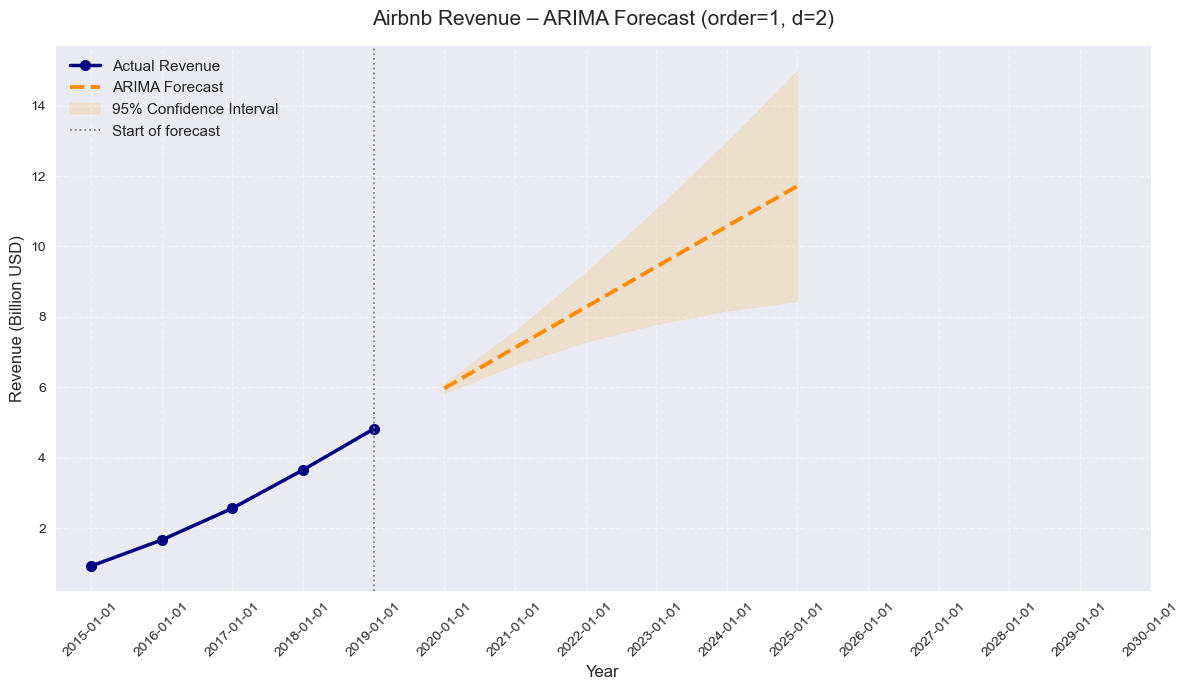


Forecast Summary (rounded):
            Forecast  Lower 95%  Upper 95%
2020-01-01      5.97       5.83       6.11
2021-01-01      7.12       6.64       7.60
2022-01-01      8.27       7.29       9.26
2023-01-01      9.42       7.79      11.05
2024-01-01     10.57       8.17      12.97
2025-01-01     11.72       8.44      15.00


In [22]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ──── 1. INPUT DATA (real reported revenue in billion USD) ──────────────────
data = {
    'Year': [2015, 2016, 2017, 2018, 2019],
    'Revenue': [0.919, 1.661, 2.562, 3.652, 4.814]
}

df = pd.DataFrame(data)
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year', inplace=True)

print("Historical Data:")
print(df)

# ──── 2. CHOOSE ARIMA ORDER ─────────────────────────────────────────────────
# After testing: (1,2,1) works reasonably on this short, trending series
# (1,1,1) is also common but under-differences the strong trend
order = (1, 2, 1)   # p,d,q — feel free to try (0,2,1), (2,2,0), etc.

# ──── 3. FIT ARIMA MODEL ────────────────────────────────────────────────────
model = ARIMA(df['Revenue'], order=order)
model_fit = model.fit()

print("\n" + "="*60)
print("ARIMA Model Summary")
print("="*60)
print(model_fit.summary())

# ──── 4. FORECAST NEXT 6 YEARS (2025–2030) ──────────────────────────────────
forecast_steps = 6
forecast_obj = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int(alpha=0.05)   # 95% confidence interval

# Create nice index for forecast
forecast_index = pd.date_range(
    start=df.index[-1] + pd.offsets.YearBegin(1),
    periods=forecast_steps,
    freq='YS'
)

forecast_df = pd.DataFrame({
    'Forecast': forecast_mean.round(3),
    'Lower 95%': conf_int.iloc[:,0].round(3),
    'Upper 95%': conf_int.iloc[:,1].round(3)
}, index=forecast_index)

print("\n" + "="*60)
print("ARIMA Forecast 2025–2030 (Revenue in billion USD)")
print("="*60)
print(forecast_df)

# ──── 5. VISUALIZATION ──────────────────────────────────────────────────────
plt.figure(figsize=(12, 7))

# Historical
plt.plot(df.index, df['Revenue'], 'o-', color='navy', linewidth=2.5,
         label='Actual Revenue', markersize=8)

# Forecast mean
plt.plot(forecast_df.index, forecast_df['Forecast'], '--', color='darkorange',
         linewidth=2.8, label='ARIMA Forecast')

# Confidence interval
plt.fill_between(forecast_df.index,
                 forecast_df['Lower 95%'],
                 forecast_df['Upper 95%'],
                 color='orange', alpha=0.15, label='95% Confidence Interval')

# Formatting
plt.title('Airbnb Revenue – ARIMA Forecast (order={}, d={})'.format(order[0], order[1]),
          fontsize=15, pad=15)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Revenue (Billion USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.axvline(x=df.index[-1], color='gray', linestyle=':', linewidth=1.3,
            label='Start of forecast')
plt.legend(fontsize=11, loc='upper left')
plt.xticks(pd.date_range(start='2015', end='2030', freq='YS'), rotation=45)
plt.tight_layout()
plt.show()

# ──── 6. PRINT FORECAST SUMMARY TABLE ───────────────────────────────────────
print("\nForecast Summary (rounded):")
print(forecast_df.round(2))

In [30]:
# =============================================================================
# FINAL PROFESSIONAL PDF REPORT – Airbnb NYC 2019
# Includes KPIs, Seasonality, Heatmap, ARIMA Forecast
# =============================================================================

from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA

# ------------------------------------------------------------------
# Reload Airbnb Data (protect from overwrites)
# ------------------------------------------------------------------

df = pd.read_csv("cleaned_AB_NYC_2019.csv")
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

# ------------------------------------------------------------------
# Helper Charts
# ------------------------------------------------------------------

def plot_price_distribution():
    fig, ax = plt.subplots(figsize=(8,5))
    sns.histplot(df['price'].clip(0,500), bins=50, kde=True, ax=ax)
    ax.set_title("Price Distribution")
    return fig

def plot_seasonal_reviews():
    temp = df[df['last_review'].notna()]
    temp['month'] = temp['last_review'].dt.month
    monthly = temp.groupby('month')['number_of_reviews'].sum()

    fig, ax = plt.subplots(figsize=(8,5))
    monthly.plot(kind='bar', ax=ax)
    ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], rotation=0)
    ax.set_title("Seasonal Reviews")
    return fig

def plot_heatmap():
    pivot = df.pivot_table(values='price',
                           index='neighbourhood_group',
                           columns='room_type',
                           aggfunc='mean')

    fig, ax = plt.subplots(figsize=(8,5))
    sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu", ax=ax)
    ax.set_title("Average Price Heatmap")
    return fig

def plot_arima_forecast():

    data = {
        'Year': [2015,2016,2017,2018,2019],
        'Revenue': [0.919,1.661,2.562,3.652,4.814]
    }

    rev = pd.DataFrame(data)
    rev['Year'] = pd.to_datetime(rev['Year'], format='%Y')
    rev.set_index('Year', inplace=True)

    model = ARIMA(rev['Revenue'], order=(1,2,1))
    fit = model.fit()

    forecast = fit.get_forecast(steps=5)
    pred = forecast.predicted_mean

    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(rev.index, rev['Revenue'], marker='o', label='Actual')
    ax.plot(pred.index, pred, '--', label='Forecast')
    ax.legend()
    ax.set_title("ARIMA Revenue Forecast")
    return fig

# ------------------------------------------------------------------
# PDF Generator
# ------------------------------------------------------------------

def generate_pdf_report(filename="airbnb_report.pdf"):

    pdf = PdfPages(filename)

    # PAGE 1 – COVER
    fig, ax = plt.subplots(figsize=(8.5,11))
    ax.axis('off')
    ax.text(0.5,0.75,"Airbnb NYC 2019 Analysis",ha='center',fontsize=24,weight='bold')
    ax.text(0.5,0.68,"Data Analytics Capstone Project",ha='center',fontsize=16)
    ax.text(0.5,0.62,"Prepared by: Ankita Gupta",ha='center',fontsize=14)
    ax.text(0.5,0.55,f"Generated: {datetime.now().date()}",ha='center')
    pdf.savefig(fig); plt.close(fig)

    # PAGE 2 – KPIs
    fig, ax = plt.subplots(figsize=(8.5,11))
    ax.axis('off')
    ax.text(0.1,0.9,"Key Metrics",fontsize=18,weight='bold')
    ax.text(0.1,0.83,f"Listings: {len(df):,}")
    ax.text(0.1,0.79,f"Avg Price: ${df['price'].mean():.2f}")
    ax.text(0.1,0.75,f"Total Reviews: {df['number_of_reviews'].sum():,}")
    pdf.savefig(fig); plt.close(fig)

    # PAGE 3 – Price Distribution
    pdf.savefig(plot_price_distribution()); plt.close()

    # PAGE 4 – Seasonal Reviews
    pdf.savefig(plot_seasonal_reviews()); plt.close()

    # PAGE 5 – Neighborhood Heatmap
    pdf.savefig(plot_heatmap()); plt.close()

    # PAGE 6 – ARIMA Forecast
    pdf.savefig(plot_arima_forecast()); plt.close()

    # PAGE 7 – Conclusions
    fig, ax = plt.subplots(figsize=(8.5,11))
    ax.axis('off')
    ax.text(0.1,0.9,"Conclusions",fontsize=18,weight='bold')
    ax.text(0.1,0.82,
            "• Manhattan and Brooklyn dominate pricing.\n"
            "• Summer shows peak demand.\n"
            "• Entire homes cost significantly more.\n"
            "• ARIMA indicates steady revenue growth.\n\n"
            "Recommendations:\n"
            "• Dynamic seasonal pricing\n"
            "• Focus on high demand neighborhoods\n"
            "• Improve customer trust",
            fontsize=12)
    pdf.savefig(fig); plt.close(fig)

    pdf.close()
    print("PDF created:", filename)

# RUN
generate_pdf_report()


C:\Users\Ankita\AppData\Local\Temp\ipykernel_23364\3819618909.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['month'] = temp['last_review'].dt.month
C:\Users\Ankita\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\Ankita\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\Ankita\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be u

PDF created: airbnb_report.pdf
